## Inititalize

Run install_libraries notebook first.

General

In [1]:
import pandas as pd
import numpy as np
from dask.distributed import Client
from dask import delayed
# import dask.dataframe as dd
import dask, ast, itertools
import dask_ml.model_selection as dcv

import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from scipy.stats import expon
from scipy import interp

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

from util import plot_confusion_matrix as pcm
from util import evaluate, feature_selection, plot_confusion_matrix, plot_roc
from util import prec_rec_curve, feature_importance, plot_class_hist, read_data, cv, gridcv

from config import read_options
from viz import Viz
from filehandler import FileHandler

%matplotlib inline

Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [ ]:
print(dask.__version__)
print(pd.__version__)

In [2]:
client = Client('Dask-Scheduler.local-dask:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 5 Cores: 10 Memory: 42.95 GB


In [ ]:
client.restart()

In [4]:
#fh = FileHandler() #s3_bucket='fmi-sasse-classification-dataset')
#viz = Viz()

In [5]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'thin'
read_options(options)

In [3]:
num_classes=3

## Loiste-JSE Recent

### Get data

In [9]:
name='loiste_jse_recent_15'

X_train, y_train, X_test, y_test = read_data('../data/{}_thin_train.csv'.format(name), 
                                             '../data/{}_thin_test.csv'.format(name),
                                             options_thin)

X_res, y_res, _, _ = read_data('../data/{}_thin_res.csv'.format(name), 
                                                       None, 
                                                       options_thin)


Train data shape: (4923, 35)
Test data shape: (1235, 35)
Train data shape: (13545, 35)


In [10]:
dfdup = pd.concat([X_train, X_test])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([X_res, X_test])
assert len(dfdup[(dfdup.duplicated())]) == 0

## Train

In [11]:
class_weights = []
for i in np.arange(0,1,.3):
    for j in np.arange(0, 1-i, .1):
        k = 1 - i - j 
        class_weights.append({0: i, 1: j, 2: k})

param_grid_rfc = {"n_estimators": [10, 100, 150, 200, 250, 500],
                  "max_depth": [3, 10, 20, 50, None],
                  "max_features": ["auto", "sqrt", "log2", None],
                  "min_samples_split": [2,5,10,50],
                  "min_samples_leaf": [1, 2, 4, 10, 20],
                  "bootstrap": [True, False],
                  "class_weight": class_weights}

In [12]:
model_rfc_thin, cv_results = cv(RandomForestClassifier(n_jobs=-1), param_grid_rfc, X_train, y_train, 50)

..performing cv search...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                                              params  mean_fit_time  \
0  {'n_estimators': 250, 'min_samples_split': 2, ...      50.717283   
1  {'n_estimators': 200, 'min_samples_split': 10,...      32.930292   
2  {'n_estimators': 10, 'min_samples_split': 50, ...       3.029477   
3  {'n_estimators': 200, 'min_samples_split': 2, ...      31.649583   
4  {'n_estimators': 250, 'min_samples_split': 5, ...      35.579596   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      3.487720         0.264338        0.056529              0.381294   
1      2.873590         0.248567        0.075965              0.384767   
2      0.476011         0.022979        0.021977              0.323237   
3      3.603249         0.222204        0.029098              0.341331   
4      2.231221         0.225483        0.033104              0.334588   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.368192              0.326773            

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1407
           1       0.20      0.06      0.09        88
           2       0.71      0.27      0.39        45

    accuracy                           0.91      1540
   macro avg       0.61      0.44      0.48      1540
weighted avg       0.88      0.91      0.89      1540

Average precision score, micro-averaged over all classes: 0.95
AUC for class 0 is 0.8148195649037306
AUC for class 1 is 0.7218335211620337
AUC for class 2 is 0.8873727238944631


<Figure size 432x288 with 0 Axes>

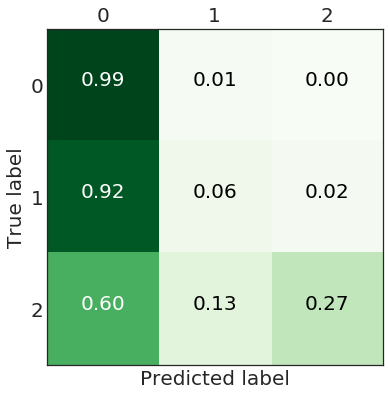

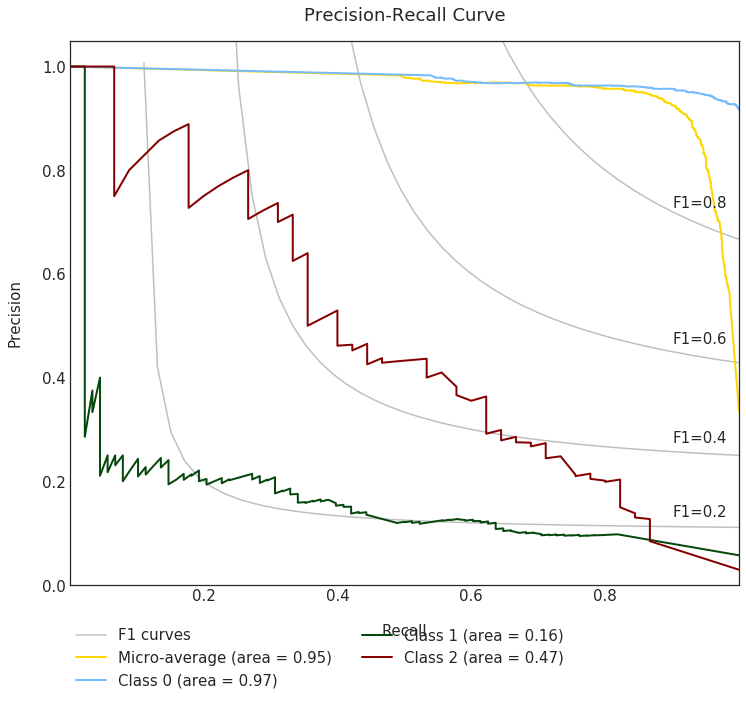

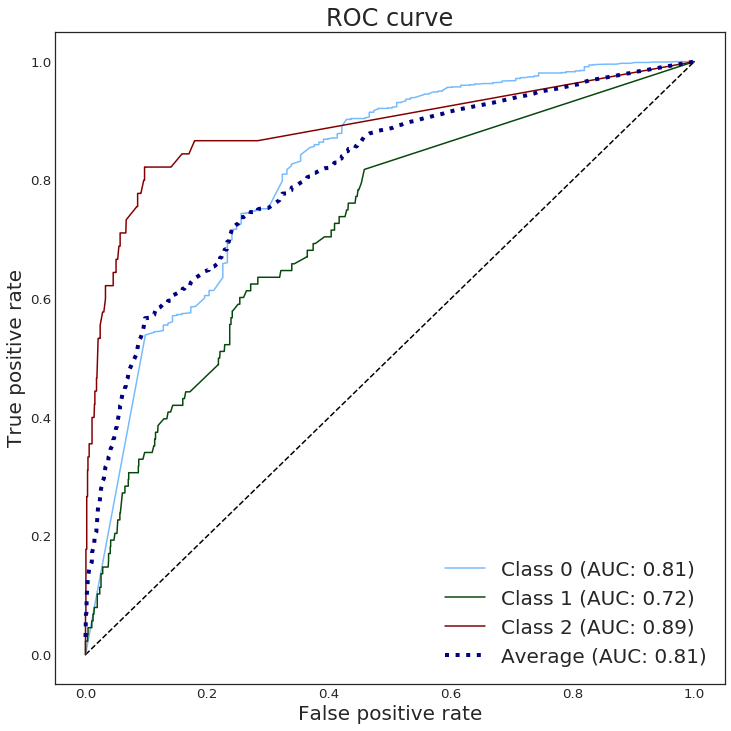

In [16]:
y_pred_proba = model_rfc_thin.predict_proba(X_test.values)
y_pred = np.argmax(y_pred_proba, axis=1)

plot_confusion_matrix(y_test, y_pred, range(0,num_classes), normalize=True, cmap=plt.cm.Greens)
prec_rec_curve(y_test, y_pred_proba, num_classes, fontsize=15)
plot_roc(y_test, y_pred_proba, num_classes)